In [0]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_path = "drive/My Drive/training"
val_path = "drive/My Drive/validation"
test_path = "drive/My Drive/test_set_images"

In [0]:
import numpy as np
np.random.seed(1)
import random
random.seed(1)

import os
import skimage.io as io
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.losses import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard
from keras.preprocessing.image import ImageDataGenerator



Using TensorFlow backend.


# Data Enrichment and Augmentation
Enrich our trainning set:
1.   Filip original image
2.   Rotate image and filpped version by {90, 180, 270} degree

In this way we get eight-fold our original data set and we consider this enriched dataset as **real** data. It makes sence as in real world satellite images may also be shown in different ways, e.g. upside-down, or horizontally mirrored. 

After this step, we preserve 10% of enriched dataset as validation set and remain as training set.

During training, we perform stochastic data augmentaion on training set; for validation, we only use the 10% data without any augmentation.



## Data Enrichment

In [0]:
# Data Enrichment - flip & rotate

for i in range(1, 101):
    im = Image.open(os.path.join(train_path, 'images', 'satImage_%.3d.png'%i))
    ma = Image.open(os.path.join(train_path, 'groundtruth', 'satImage_%.3d.png'%i))

    im_f = im.transpose(Image.FLIP_LEFT_RIGHT)
    io.imsave(os.path.join(train_path, 'images', 'satImage_%.3d_f.png'%i), im_f)

    ma_f = ma.transpose(Image.FLIP_LEFT_RIGHT)
    io.imsave(os.path.join(train_path, 'groundtruth', 'satImage_%.3d_f.png'%i), ma_f)
  
  
    for angle in [90, 180, 270]:
        im_r = im.rotate(angle)
        io.imsave(os.path.join(train_path, 'images', 'satImage_%.3d_%.3d.png'%(i, angle)), im_r)

        im_f_r = im_f.rotate(angle)
        io.imsave(os.path.join(train_path, 'images', 'satImage_%.3d_f_%.3d.png'%(i, angle)), im_f_r)

        ma_r = ma.rotate(angle)
        io.imsave(os.path.join(train_path, 'groundtruth', 'satImage_%.3d_%.3d.png'%(i, angle)), ma_r)

        ma_f_r = ma_f.rotate(angle)
        io.imsave(os.path.join(train_path, 'groundtruth', 'satImage_%.3d_f_%.3d.png'%(i, angle)), ma_f_r)


In [0]:
train_val_images = os.listdir(os.path.join(train_path, 'images'))

from sklearn.model_selection import train_test_split
train_images, val_images = train_test_split(train_val_images, test_size=0.2, random_state=1)
len(train_images), len(val_images)

(640, 160)

In [0]:
!mkdir "/content/drive/My Drive/validation"
!mkdir "/content/drive/My Drive/validation/images"
!mkdir "/content/drive/My Drive/validation/groundtruth"

In [0]:
val_path = "/content/drive/My Drive/validation"
for im in val_images:
    os.rename(os.path.join(train_path, 'images', im), os.path.join(val_path, 'images', im))
    os.rename(os.path.join(train_path, 'groundtruth', im), os.path.join(val_path, 'groundtruth', im))

## Data Augmentation

In [0]:
def preprocess_mask(mask):
    mask = mask/255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return mask
  
def preprocess_img(img):
    return img/255

In [0]:
def trainvalGenerator(batch_size, train_path, val_path,
                      image_folder, mask_folder,
                      aug_dict, train_dir = None, val_dir = None,
                      target_size = (400,400), seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    
    
    # Train
    image_dict = aug_dict.copy()
    image_dict["preprocessing_function"] = preprocess_img
    image_datagen = ImageDataGenerator(**image_dict)
    
    mask_dict = aug_dict.copy()
    mask_dict["preprocessing_function"] = preprocess_mask
    mask_datagen = ImageDataGenerator(**mask_dict)
    
    image_generator_train = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = "rgb",
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = train_dir,
        save_prefix  = "image",
        seed = seed)
    
    mask_generator_train = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = "grayscale",
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = train_dir,
        save_prefix  = "mask",
        seed = seed)
    
    # Validation
    image_datagen = ImageDataGenerator(preprocessing_function=preprocess_img)
    mask_datagen = ImageDataGenerator(preprocessing_function=preprocess_mask)
    
    image_generator_val = image_datagen.flow_from_directory(
        val_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = "rgb",
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = val_dir,
        save_prefix  = "image",
        seed = seed+1,
        shuffle = False
    )
    
    mask_generator_val = mask_datagen.flow_from_directory(
        val_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = "grayscale",
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = val_dir,
        save_prefix  = "mask",
        seed = seed+1,
        shuffle = False
    )
    
    return zip(image_generator_train, mask_generator_train), zip(image_generator_val, mask_generator_val)

In [0]:
# argument for data augmentation
data_gen_args = dict(rotation_range=45,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

In [0]:
!rm -rf train_image
!rm -rf val_image
!mkdir train_image
!mkdir val_image

In [0]:
trainGen, valGen = trainvalGenerator(batch_size=2, 
                                     train_path=train_path, val_path=val_path,
                                     image_folder='images', mask_folder='groundtruth',
                                     aug_dict=data_gen_args, 
                                     train_dir = "train_image", # Set it to None if you don't want to save
                                     val_dir = None, # Set it to None if you don't want to save
                                     target_size = (400, 400), seed = 1)

Found 640 images belonging to 1 classes.
Found 640 images belonging to 1 classes.
Found 160 images belonging to 1 classes.
Found 160 images belonging to 1 classes.


# Metrics and Loss

In [0]:
# credits: https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
# https://arxiv.org/pdf/1606.04797.pdf
# https://arxiv.org/pdf/1707.03237.pdf

# credits: https://github.com/petrosgk/Kaggle-Carvana-Image-Masking-Challenge/blob/master/model/losses.py
from keras.losses import binary_crossentropy
import keras.backend as K


def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [0]:
# foreground_threshold = 0.25

# def patch_to_label(patch):
#     df = np.mean(patch)
#     if df > foreground_threshold:
#         return 1
#     else:
#         return 0
      
# def get_label(y, patch_size=16):
#     label = []
#     y_array = K.eval(y[:,:,:,0])
#     for im in y_array:
#       for j in range(0, im.shape[1], patch_size):
#         for i in range(0, im.shape[0], patch_size):
#             patch = im[i:i + patch_size, j:j + patch_size]
#             label.append(patch_to_label(patch))
#     return np.array(label)
  
# def patch_f1(y_true, y_pred):
#     true_label = get_label(y_true)
#     pred_label = get_label(y_pred)
#     return f1(true_label, pred_label)

In [0]:
# # credits: https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras

# def f1(y_true, y_pred):
#     #y_pred = K.round(y_pred)
#     #y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
#     tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
#     tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
#     fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
#     fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

#     p = tp / (tp + fp + K.epsilon())
#     r = tp / (tp + fn + K.epsilon())

#     f1 = 2*p*r / (p+r+K.epsilon())
#     f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
#     return K.mean(f1)
  
# def f1_loss(y_true, y_pred):
    
#     tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
#     tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
#     fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
#     fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

#     p = tp / (tp + fp + K.epsilon())
#     r = tp / (tp + fn + K.epsilon())

#     f1 = 2*p*r / (p+r+K.epsilon())
#     f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
#     return 1 - K.mean(f1)

# Network

In [0]:
def conv2d_block(input_tensor, n_filter, kernel_size=3, batchnorm=True, activation='relu'):
    # first layer
    x = Conv2D(n_filter, kernel_size=kernel_size, kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    # second layer
    x = Conv2D(n_filter, kernel_size=kernel_size, kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

In [0]:
def unet(pretrained_weights = None,
         input_size = (None,None,3),
         n_filter=16,
         activation='relu',
         dropout=True, dropout_rate=0.5,
         batchnorm=True,
         loss=binary_crossentropy,
         optimizer=Adam(lr=1e-4)
        ):
  
    # 3
    inputs = Input(input_size)
    
    # down path
    # n_filter
    conv1 = conv2d_block(inputs, n_filter, kernel_size=3, batchnorm=batchnorm, activation=activation)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # n_filter*2
    conv2 = conv2d_block(pool1, n_filter*2, kernel_size=3, batchnorm=batchnorm, activation=activation)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # n_filter*4
    conv3 = conv2d_block(pool2, n_filter*4, kernel_size=3, batchnorm=batchnorm, activation=activation)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # n_filter*8
    conv4 = conv2d_block(pool3, n_filter*8, kernel_size=3, batchnorm=batchnorm, activation=activation)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # central path
    # n_filter*16
    conv5 = conv2d_block(pool4, n_filter*16, kernel_size=3, batchnorm=batchnorm, activation=activation)

    # up path
    # n_filter*8
    up6 = Conv2DTranspose(n_filter*8, kernel_size=2, strides=2, kernel_initializer="he_normal", padding='same')(conv5)
    merge6 = concatenate([conv4, up6], axis = 3)
    merge6 = Dropout(dropout_rate)(merge6) if dropout else merge6
    conv6 = conv2d_block(merge6, n_filter*8, kernel_size=3, batchnorm=False, activation=activation)
    
    # n_filter*4
    up7 = Conv2DTranspose(n_filter*4, kernel_size=2, strides=2, kernel_initializer="he_normal", padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis = 3)
    merge7 = Dropout(dropout_rate)(merge7) if dropout else merge7
    conv7 = conv2d_block(merge7, n_filter*4, kernel_size=3, batchnorm=False, activation=activation)
    
    # n_filter*2
    up8 = Conv2DTranspose(n_filter*2, kernel_size=2, strides=2, kernel_initializer="he_normal", padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis = 3)
    merge8 = Dropout(dropout_rate)(merge8) if dropout else merge8
    conv8 = conv2d_block(merge8, n_filter*2, kernel_size=3, batchnorm=False, activation=activation)
    
    # n_filter
    up9 = Conv2DTranspose(n_filter, kernel_size=2, strides=2, kernel_initializer="he_normal", padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis = 3)
    merge9 = Dropout(dropout_rate)(merge9) if dropout else merge9
    conv9 = conv2d_block(merge9, n_filter, kernel_size=3, batchnorm=False, activation=activation)
    
    # classifier
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = optimizer, loss = loss, metrics = [f1, 'accuracy'])
    
    if(pretrained_weights):
        model.load_weights(filepath=pretrained_weights)

    return model

In [0]:
model = unet(pretrained_weights='drive/My Drive/weights_64_0.2_elu_dice.h5', n_filter=64, activation='elu', dropout_rate=0.2, loss=dice_loss, optimizer=Adam(lr=1e-6))
# model.summary()

# Train

In [0]:
callbacks = [
#     ModelCheckpoint('weights_no_val.h5', monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=9, verbose=1, min_delta=1e-4),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_delta=1e-4),
    ModelCheckpoint('drive/My Drive/weights_64_0.2_elu_dice_train_more.h5', monitor='val_loss', save_best_only=True, verbose=1),
    TensorBoard(log_dir='tensorboard/', write_graph=True, write_images=True)
]

In [0]:
print('*'*30)
print('Fitting model...')
print('*'*30)
history = model.fit_generator(generator=trainGen, steps_per_epoch=100,
                              validation_data=valGen, validation_steps=80,
                              epochs=100, callbacks=callbacks)

******************************
Fitting model...
******************************
Epoch 1/100
100/100 [==============================] - 112s 1s/step - loss: 0.1014 - f1: 0.8986 - acc: 0.9579 - val_loss: 0.1128 - val_f1: 0.8872 - val_acc: 0.9570

Epoch 00001: val_loss did not improve from 0.11230
Epoch 2/100
100/100 [==============================] - 111s 1s/step - loss: 0.0903 - f1: 0.9097 - acc: 0.9647 - val_loss: 0.1127 - val_f1: 0.8874 - val_acc: 0.9571

Epoch 00002: val_loss did not improve from 0.11230
Epoch 3/100
100/100 [==============================] - 111s 1s/step - loss: 0.0840 - f1: 0.9160 - acc: 0.9667 - val_loss: 0.1128 - val_f1: 0.8872 - val_acc: 0.9570

Epoch 00003: val_loss did not improve from 0.11230
Epoch 4/100
100/100 [==============================] - 111s 1s/step - loss: 0.0862 - f1: 0.9138 - acc: 0.9666 - val_loss: 0.1126 - val_f1: 0.8874 - val_acc: 0.9570

Epoch 00004: val_loss did not improve from 0.11230
Epoch 5/100
100/100 [==============================] - 11

KeyboardInterrupt: ignored

In [0]:
!cp weights_32_0.2_elu_dice_train_more.h5 "drive/My Drive"
# # !cp weights_32_drop_relu.h5 "drive/My Drive"

# Predict

In [0]:
import skimage.io as io
def testGenerator(test_path, num_image = 50):
    for i in range(1,num_image+1):
        img = io.imread(os.path.join(test_path, "test_%d"%i, "test_%d.png"%i))
        img = img / 255
        img = np.reshape(img,(1,)+img.shape)
        yield img

In [0]:
testGene = testGenerator(test_path)
# model_predict = unet(pretrained_weights = "weights_no_val_32.h5", input_size = (608,608,3))

In [0]:
result = model.predict_generator(testGene, 50, verbose=1)

50/50 [==============================] - 39s 779ms/step


In [0]:
def saveResult(save_path, npyfile):
    for i,item in enumerate(npyfile):
        img = item[:,:,0]
        io.imsave(os.path.join(save_path, "%d_predict.png"%(i+1)), img)

!rm -rf test
!mkdir test        
saveResult("test", result)

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [0]:
import os
import numpy as np
import matplotlib.image as mpimg
import re

foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))

In [0]:
submission_filename = 'submission_64_0.2_elu_dice_train_more.csv'
image_filenames = []
predict_path = 'test/'
for i in range(1, 51):
    image_filename = predict_path + '%d' % i + '_predict.png'
#     print(image_filename)
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)

In [0]:
!cp submission_64_0.2_elu_dice_train_more.csv "drive/My Drive"

## Postprocessing

In [0]:
from skimage.morphology import 

In [0]:
im = plt.imread(os.path.join("test", "%d_predict.png"%20))
im_c = opening(im, square(8))

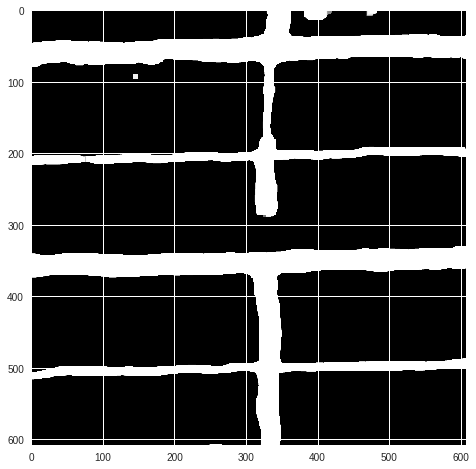

In [0]:
plt.figure(figsize=(8,8))
plt.imshow(im_c, 'gray')

In [0]:
!mkdir test_open
for i in range(1, 51):
    im = plt.imread(os.path.join("test", "%d_predict.png"%i))
    im_c = opening(im, square(8))
    io.imsave(os.path.join("test_open", "%d_predict.png"%i), im_c)

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [0]:
submission_filename = 'submission_64_0.2_elu_dice_train_more_open8.csv'
image_filenames = []
predict_path = 'test_open/'
for i in range(1, 51):
    image_filename = predict_path + '%d' % i + '_predict.png'
#     print(image_filename)
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)